In [94]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array

import visualkeras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

In [70]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))

Num GPUs Available:  1


In [71]:
# Define the train directory
train_dir = 'data/train/'
test_dir = 'data/test/'

In [72]:
# Get the list of image filenames
filenames = os.listdir(train_dir)

# Create a list of dictionaries, where each dictionary represents an image with its filename and category
data = []
for filename in filenames:
    if filename.startswith('cat'):
        category = '0'
    elif filename.startswith('dog'):
        category = '1'
    else:
        continue

    data.append({'filename': filename, 'category': category})

# Convert the list of dictionaries to a pandas DataFrame
df = pd.DataFrame(data)

# Check the first few rows of the DataFrame
df.head()


,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0


In [73]:
df.head(-5)

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0
...,...,...
24990,dog.9990.jpg,1
24991,dog.9991.jpg,1
24992,dog.9992.jpg,1
24993,dog.9993.jpg,1


In [74]:
df.shape

(25000, 2)

In [75]:
df[df['category'] == '0']


,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0
...,...,...
12495,cat.9995.jpg,0
12496,cat.9996.jpg,0
12497,cat.9997.jpg,0
12498,cat.9998.jpg,0


<h2>Data Preprocessing</h2>

<Axes: xlabel='category'>

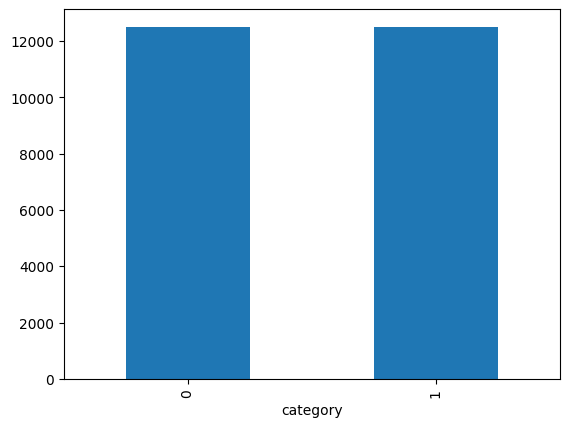

In [76]:
df['category'].value_counts().plot.bar()

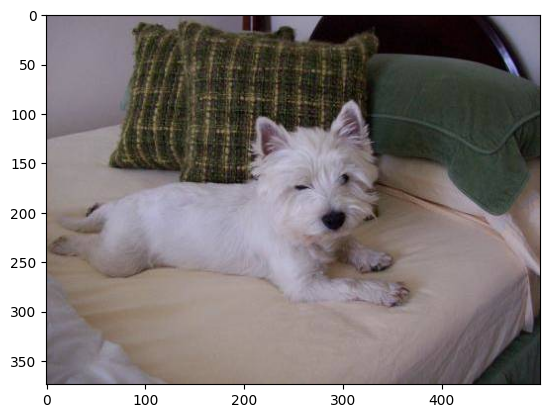

In [77]:
sample = random.choice(filenames)
img = np.asarray(Image.open("data/train/"+sample))
# image = load_img()
plt.imshow(img)


In [78]:
# Prepare Test and Train Data
train_df, validate_df = train_test_split(df, test_size=0.2)
train_df = train_df.reset_index()
validate_df = validate_df.reset_index()


total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

In [79]:
validate_df

,index,filename,category
0,16849,dog.2662.jpg,1
1,1905,cat.11711.jpg,0
2,13657,dog.11038.jpg,1
3,2846,cat.1309.jpg,0
4,9988,cat.7738.jpg,0
...,...,...,...
4995,15117,dog.12352.jpg,1
4996,18068,dog.376.jpg,1
4997,13569,dog.1096.jpg,1
4998,6813,cat.4880.jpg,0


In [80]:
# define the width and height of the images that will be fed into the neural network
img_width, img_height = 128, 128
batch_size = 32

In [81]:
# Create an ImageDataGenerator for the training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [82]:
# Create an ImageDataGenerator for the validation data
validate_datagen = ImageDataGenerator(rescale=1./255)

In [83]:
# Get the list of test image filenames
test_filenames = os.listdir(test_dir)

# Create a DataFrame for the test dataset
test_df = pd.DataFrame({
    'filename': test_filenames
})

In [84]:
# Generate training data
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    train_dir, 
    x_col='filename',
    y_col='category',
    target_size=(img_width, img_height),
    class_mode='binary',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


In [85]:
# Generate validation data
validate_generator = validate_datagen.flow_from_dataframe(
    validate_df, 
    train_dir, 
    x_col='filename',
    y_col='category',
    target_size=(img_width, img_height),
    class_mode='binary',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


<h2>Model training</h2>

In [86]:
model = Sequential()

# First convolutional layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)))
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Second convolutional layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Third convolutional layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flatten and dense layers
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  # binary classification

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 conv2d_16 (Conv2D)          (None, 124, 124, 64)      18496     
                                                                 
 batch_normalization_12 (Bat  (None, 124, 124, 64)     256       
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 62, 62, 64)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 60, 60, 64)       

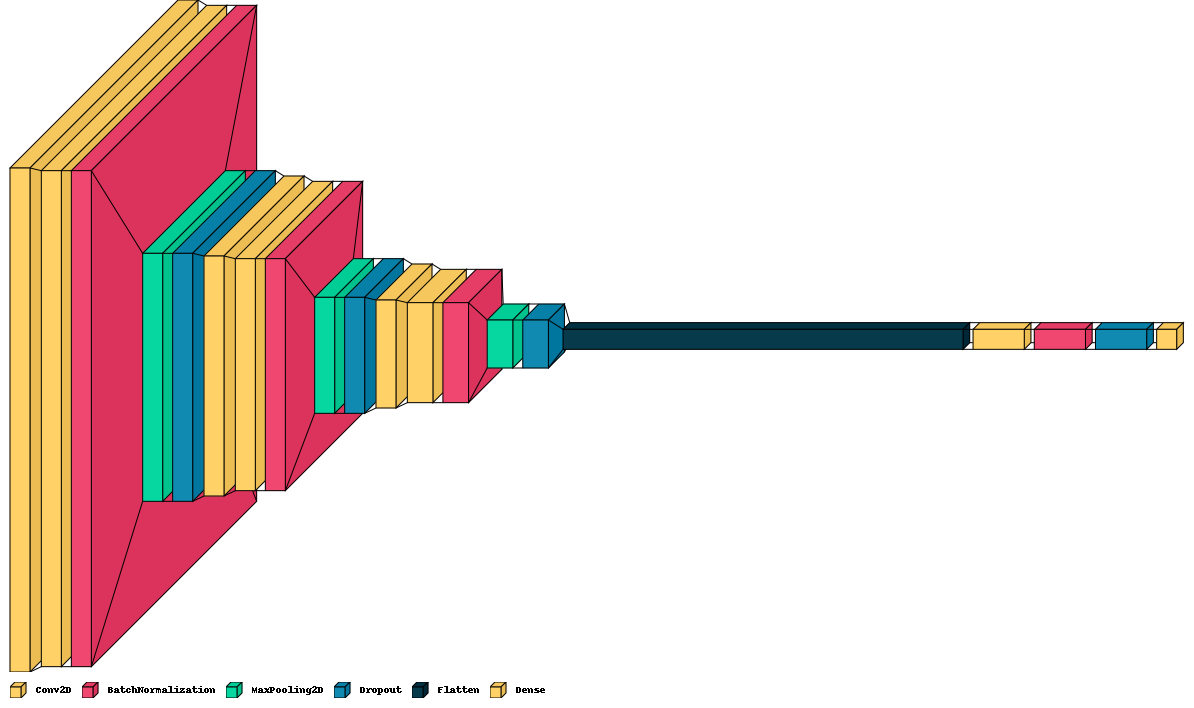

In [87]:
# Modify the layer names in the model
for i, layer in enumerate(model.layers):
    layer._name = f'{layer.__class__.__name__}-{i}'

# Create a visual representation of the model's architecture with custom layer names
visualkeras.layered_view(model, legend=True)

<h2>Model fitting</h2>

In [89]:
# Define the checkpoint path and file name
checkpoint_filepath = 'best_model.h5'

# Create the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    save_freq='epoch'
)

epochs = 20

# Train the model 
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validate_generator,
    steps_per_epoch=total_train // batch_size,
    validation_steps=total_validate // batch_size,
    callbacks=[checkpoint_callback]  # Add the checkpoint_callback to the list of callbacks
)

Epoch 1/20
625/625 [==============================] - ETA: 0s - loss: 0.7264 - accuracy: 0.6276
Epoch 1: val_loss improved from inf to 0.72216, saving model to best_model.h5
625/625 [==============================] - 71s 110ms/step - loss: 0.7264 - accuracy: 0.6276 - val_loss: 0.7222 - val_accuracy: 0.6348
Epoch 2/20
625/625 [==============================] - ETA: 0s - loss: 0.5655 - accuracy: 0.7085
Epoch 2: val_loss did not improve from 0.72216
625/625 [==============================] - 68s 109ms/step - loss: 0.5655 - accuracy: 0.7085 - val_loss: 0.8385 - val_accuracy: 0.6140
Epoch 3/20
625/625 [==============================] - ETA: 0s - loss: 0.4928 - accuracy: 0.7595
Epoch 3: val_loss improved from 0.72216 to 0.43798, saving model to best_model.h5
625/625 [==============================] - 69s 111ms/step - loss: 0.4928 - accuracy: 0.7595 - val_loss: 0.4380 - val_accuracy: 0.7905
Epoch 4/20
625/625 [==============================] - ETA: 0s - loss: 0.4333 - accuracy: 0.8001
Epoch 4

In [91]:
validation_loss, validation_accuracy = model.evaluate(validate_generator, steps=total_validate // batch_size)
print(f'Validation loss: {validation_loss:.4f}')
print(f'Validation accuracy: {validation_accuracy:.4f}')


156/156 [==============================] - 6s 35ms/step - loss: 0.1334 - accuracy: 0.9495
Validation loss: 0.1334
Validation accuracy: 0.9495


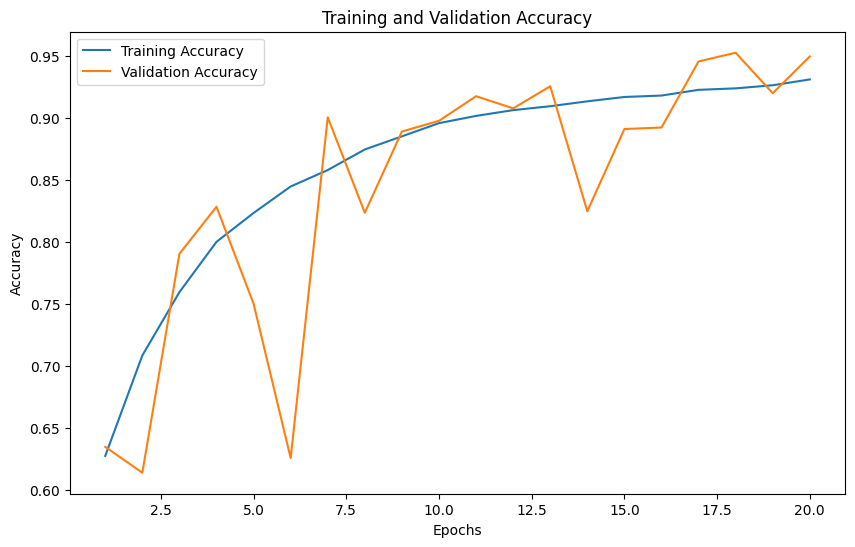

In [92]:
# Retrieve the accuracy and validation accuracy values
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create a range of epoch numbers
epochs_range = range(1, len(accuracy) + 1)

# Plot the training and validation accuracy curves
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

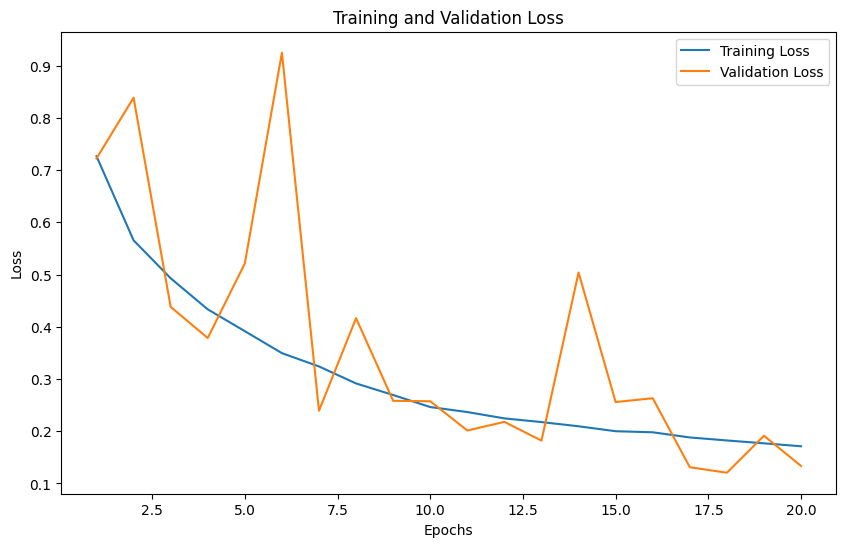

In [93]:
# Retrieve the loss and validation loss values
loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a range of epoch numbers
epochs_range = range(1, len(loss) + 1)

# Plot the training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [104]:
best_model = load_model(checkpoint_filepath)

<h2>Model test</h2>

In [105]:
# Load the image and preprocess it
def preprocess_image(image_path, target_size):
    img = Image.open(image_path)
    img = img.resize(target_size)
    img = img_to_array(img) / 255.0
    img = np.expand_dims(img, axis=0)
    return img

# Predict the class of an image and print the probabilities
def predict_image(image_path, best_model):
    img = preprocess_image(image_path, (img_width, img_height))
    prediction = best_model.predict(img)[0][0]

    # Calculate the percentage of chance for both cat and dog predictions
    dog_probability = prediction * 100
    cat_probability = (1 - prediction) * 100

    print(f"Probability of the image being a dog: {dog_probability:.2f}%")
    print(f"Probability of the image being a cat: {cat_probability:.2f}%")

In [106]:
# Test the model with a new image
image_path = "./data/test/5.jpg"
predict_image(image_path, model)

1/1 [==============================] - 0s 21ms/step
Probability of the image being a dog: 0.02%
Probability of the image being a cat: 99.98%
